# Elastic properties

In [1]:
import numpy as np
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.io import read
from ase.units import GPa, kg
from calorine.calculators import CPUNEP
from calorine.tools import get_elastic_stiffness_tensor, get_force_constants, relax_structure
from matplotlib import pyplot as plt
from pandas import DataFrame

This tutorial illustrates the calculation of the elastic stiffness tensor $c_{ij}$ and its relation to the sound velocity.
In the first part we use silver in its face-centered cubic (FCC) ground state structure described by an effective medium theory (EMT) potential as a particular simple example.
In the second part we then consider the orthorhombic structure of CsPbI<sub>3</sub>, which allows us to demonstrate the difference between relaxed $c_{ij}$ and clamped elastic constants $c_{ij}^0$.

For background on crystal elasticity and the role of symmetry you can consult, e.g., Nye, *Physical Properties of Crystals: Their Representation by Tensors and Matrices*, Oxford University Press (1957).

All models and structures required for running this and the other tutorial notebooks can be obtained from [Zenodo](https://zenodo.org/record/10658778).
The files are also available in the `tutorials/` folder in the [GitLab repository](https://gitlab.com/materials-modeling/calorine/-/tree/master/tutorials).

## Face-centered cubic silver

### Elastic constants and relation to sound velocities

First we set up the primitive structure of FCC Ag and relax the cell.

In [2]:
structure = bulk('Ag')
calculator = EMT()
structure.calc = calculator
relax_structure(structure, fmax=0.0001)

The elastic stiffness tensor $c_{ij}$ can then be readily calculated using the `get_elastic_stiffness_tensor` function.
The latter applies a series of deformations to the cell and fits the resulting strain energy to a Taylor expansion in strain, in which the components of the elastic stiffness tensor appear as expansion coefficients.

In [3]:
cij = get_elastic_stiffness_tensor(structure)
with np.printoptions(precision=1, suppress=True):
    print(cij)

[[125.9  87.3  87.3   0.   -0.    0. ]
 [ 87.3 125.9  87.3  -0.    0.    0. ]
 [ 87.3  87.3 125.9  -0.   -0.    0. ]
 [ -0.   -0.   -0.   54.2  -0.   -0. ]
 [ -0.    0.   -0.   -0.   54.2  -0. ]
 [  0.    0.    0.   -0.   -0.   54.2]]


The elastic constants are related to the sound velocity along different crystal directions.
In particular $c_{11}$ is related to the longitudinal speed of sound along $\left<100\right>$ in the long-wavelength limit (i.e., $\boldsymbol{q}\rightarrow 0$) according to

$$
c_s^{\left<100\right>} = \sqrt{\frac{c_{11}}{\rho}},
$$

where $\rho$ is the mass density of the material.

Let us now test this relationship.
For simplicity of presentation, we use the conventional 4-atom unit cell in the following, for which the cell axes are oriented along the Cartesian directions.

In [4]:
structure = bulk('Ag', cubic=True)
calculator = EMT()
structure.calc = calculator
relax_structure(structure, fmax=0.0001)

We compute the force constants using the `get_force_constants` function and then use methods of the [Phonopy object](https://phonopy.github.io/phonopy/phonopy-module.html) returned by the latter to calculate the group velocities at $\boldsymbol{q}=(\delta, 0, 0)$ with $\delta = 0.01$.
This $\boldsymbol{q}$-point lies along $\left<100\right>$ and the small $\delta$-value mimics the long-wavelength limit, i.e., $\boldsymbol{q} \rightarrow 0$.

In [5]:
phonon = get_force_constants(structure, calculator, [2, 2, 2])
phonon.run_band_structure([[[0.01, 0, 0]]], with_group_velocities=True)
band = phonon.get_band_structure_dict()

Next we select the speed of sound of the LA branch and convert it to SI unitss (m/s).

In [6]:
group_velocities = np.linalg.norm(band['group_velocities'][0], axis=2) * 1e-10 / 1e-12  # Å/ps --> m/s
speed_of_sound = group_velocities[0][2]
print(f'speed of sound, LA, 100 : {speed_of_sound:7.1f} m/s')

speed of sound, LA, 100 :  3415.1 m/s


Combining the speed of sound with the mass density, then yields the elastic constant $c_{11}$.

In [7]:
density = np.sum(structure.get_masses()) / structure.get_volume() / kg / 1e-30  # amu/Å^3 --> kg/m^3
print(f'density                 : {density:7.1f} kg/m^3')

elastic_constant = speed_of_sound ** 2 * density * 1e-9  # Pa --> GPa
print(f'elastic constant c11    : {elastic_constant:7.1f} GPa')

density                 : 10677.9 kg/m^3
elastic constant c11    :   124.5 GPa


The result of 124.5 GPa is in good agreement with the value of 125.9 GPa obtained above by direct evaluation of the elastic stiffness tensor.

### Presssure dependence

We can now also readily evaluate the variation of the elastic constants with pressure.

In [8]:
data = []
for volsc in np.arange(0.88, 1.05, 0.04):
    structure_strained = structure.copy()
    cell = structure_strained.get_cell()
    cell *= volsc ** (1 / 3)
    structure_strained.set_cell(cell, scale_atoms=True)
    structure_strained.calc = calculator
    relax_structure(structure_strained, constant_volume=True)
    
    cij_rlx = get_elastic_stiffness_tensor(structure_strained)
    pressure = -np.sum(structure_strained.get_stress()[:3]) / 3 / GPa
    
    data.append(dict(volsc=volsc,
                     pressure=pressure,
                     volume=structure_strained.get_volume() / len(structure_strained),
                     c11=cij_rlx[0][0],
                     c12=cij_rlx[0][1],
                     c44=cij_rlx[3][3],
                    ))
df = DataFrame(data)

The results show a stiffening of the elastic constants with pressure, which is expected for this system.

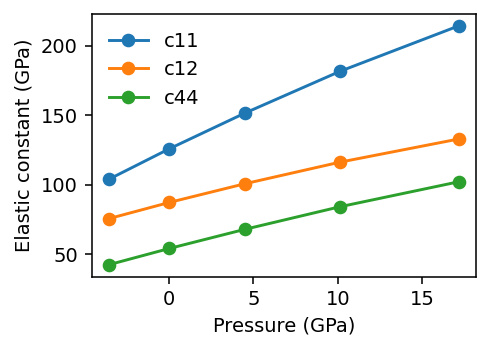

In [9]:
fig, ax = plt.subplots(figsize=(3.6, 2.6), dpi=140)

for col in df:
    if not col.startswith('c'):
        continue
    ax.plot(df.pressure, df[col], 'o-', label=col)

ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel('Elastic constant (GPa)')
ax.legend(frameon=False)

plt.tight_layout()

## CsPbI<sub>3</sub>

In materials with internal degrees of freedom one can distinguish the so-called relaxed $c_{ij}$ and clamped elastic constants $c_{ij}^0$.
In the former case, the ionic positions are allowed to relax after application of a macroscopic strain, whereas in the latter the relative coordinates are kept fixed.

To illustrate this effect, we here consider the elastic stiffness tensors in orthorhombic structure of CsPbI<sub>3</sub>, which we describe using a neuroevolution potential (NEP) taken from [Fransson *et al.*](https://pubs.acs.org/doi/10.1021/acs.jpcc.3c01542).

In [10]:
structure = read('CsPbI3-orthorhombic-Pnma.xyz')
calculator = CPUNEP('nep-CsPbI3-SCAN.txt')
structure.calc = calculator
relax_structure(structure, fmax=0.0001)

Next we can compute the relaxed (`clamped=True`; default) and clamped (`clamped=False`) elastic stiffness tensors.
Since this is a rather soft material, we tighten the condition on the convergence of the forces (`fmax=1e-5`).

In [11]:
cij_rlx = get_elastic_stiffness_tensor(structure, fmax=1e-5)
cij_clamped = get_elastic_stiffness_tensor(structure, clamped=True)

with np.printoptions(precision=1, suppress=True):
    print('Relaxed elastic constants')
    print(cij_rlx)
    print('')
    print('Clamped elastic constants')
    print(cij_clamped)

Relaxed elastic constants
[[16.7 14.9 10.1 -0.  -0.   0. ]
 [14.9 25.3  9.5  0.  -0.   0. ]
 [10.1  9.5 31.1 -0.   0.  -0. ]
 [-0.   0.  -0.   6.1  0.  -0. ]
 [-0.  -0.   0.   0.   4.6 -0. ]
 [ 0.   0.  -0.  -0.  -0.  11.4]]

Clamped elastic constants
[[31.1 17.7  5.9  0.  -0.  -0. ]
 [17.7 34.9  5.2  0.  -0.   0. ]
 [ 5.9  5.2 46.8 -0.   0.  -0. ]
 [ 0.   0.  -0.   7.  -0.  -0. ]
 [-0.  -0.   0.  -0.   6.5  0. ]
 [-0.   0.  -0.  -0.   0.  18.4]]


Evidently in this material there is a pronounced difference between the relaxed and clamped elastic constants, which is related to the rather soft interactions.